References -- Growing NCA paper and code:

*   https://distill.pub/2020/growing-ca/
*   https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/growing_ca.ipynb

Imports:

In [2]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from IPython.display import Image, HTML, clear_output

import tensorflow as tf
from tensorflow import keras
from keras import layers
import random

from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import Dense
from keras.layers import concatenate
from keras import Model
from keras import Input
import keras

Params,etc.

In [3]:
TARGET_EMOJI = "🦎" #@param {type:"string"} #can replace with any google emoji
code = hex(ord(TARGET_EMOJI))[2:].lower()
print(code) #used to look up from emoji website
TARGET_url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
print(TARGET_url)
IMAGE_SIZE=72 #they say they do 64x64 but actually use 72
TARGET_SIZE = 40 #size of emojis i think
TARGET_PADDING = (IMAGE_SIZE-TARGET_SIZE)//2
num_channels=16

1f98e
https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u1f98e.png?raw=true


Display functions taken from Growing NCA:

<ipython-input-4-64b2e41ae4ae>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS) #lower res/thumbnail


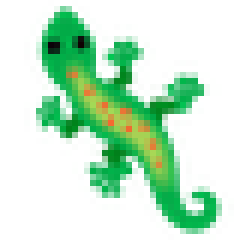

In [4]:
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  #print(r.content)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS) #lower res/thumbnail
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha (this alpha is opacity)
  img[..., :3] *= img[..., 3:4]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

target_img=load_image(TARGET_url,TARGET_SIZE)
#shape is (40, 40, 4) = x,y,RGBA
imshow(zoom(to_rgb(target_img), 6), fmt='png')

In [5]:
def calc_loss(y_true,y_pred): #taken from Growing NCA!
  loss=tf.reduce_mean(tf.square(y_true[...,:4]-y_pred[...,:4]),[-2, -3, -1])
  return loss

In [6]:
class CA():

  def __init__(self,target_img):
    print("Seed and target initialized")
    self.nrows=IMAGE_SIZE
    self.ncols=IMAGE_SIZE
    self.update_count=0
    self.padded_target=self.pad_target(target_img)
    self.model=model_step
    self.opt=opt
    self.set_seed()
    self.apply_model_step(self.state_grid) #dummy evaluation so model is completely initialized

  def set_seed(self):
    self.state_grid= self.make_array(num_channels) #initialize grid with zeros
    self.state_grid[0,self.nrows//2,self.ncols//2,3:]=1 #seed's hidden channels are 1

  def __repr__(self): #to see channel values
    s=''
    for row in range(self.nrows):
      for col in range(self.ncols):
        s+=f"{row},{col}:{self.state_grid[0,row,col,:]}\n"
    return s

  def make_array(self, nchannels): #the first index allows for the depthwise conv bc it wants a 4D input
    return np.zeros((1,self.nrows,self.ncols, nchannels),np.float32) #self, height,width,16 channels with everything 32 bit floating point

  def pad_target(self,target):
    p=TARGET_PADDING
    padded= np.pad(target,[(p,p),(p,p),(0,0)])#Dont pad the channels
    return np.array([padded])

  @tf.function
  def get_living_mask(self,x):
    alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1 #kernel size of 3, returns false if no neighbors are mature

  def get_RGBA(self):
    return self.state_grid[...,0:4]

  def display_current_state(self,current_grid):
    imshow(zoom(to_rgb(current_grid[0]), 6), fmt='png')

  def grow(self,nsteps):
    self.set_seed()
    x=self.state_grid
    step=1
    self.display_current_state(x)
    for i in range(nsteps):
      print("Time step ",step)
      x=self.apply_model_step(x)
      self.display_current_state(x)
      step+=1
    loss = tf.reduce_mean(calc_loss(self.padded_target,x))
    print("Current Loss: ",tf.get_static_value(loss))

  @tf.function
  def apply_model_step(self,input_img):
    alive_before_update = self.get_living_mask(input_img) #is it currently alive?
    delta=self.model(input_img) #amount to change state_grid by
    #stochastic_mask = tf.random.uniform(tf.shape(input_img[:, :, :, :1]))<=.5
    new_img=input_img+delta#*tf.cast(stochastic_mask,tf.float32)
    still_living = self.get_living_mask(new_img) #are the cells alive after update?
    live= tf.cast(alive_before_update&still_living,tf.float32)
    return new_img*live

  @tf.function
  def train_step(self,input_img):
    #decide how many iterations of the base model
    #RNN_length = tf.random.uniform([], 64, 96, tf.int32) #allows it to be a variable depth rnn
    RNN_length=100
    x=input_img
    with tf.GradientTape() as g:
      #iteratively apply steps in the RNN (unrolled)
      for i in range(RNN_length):
        #chain our model_steps
        #all the weights are being treated as variables (symbolically) rather than substituting the current weight values
        x = self.apply_model_step(x)
      loss = tf.reduce_mean(calc_loss(self.padded_target,x))
    #g.gradient takes the gradient and feeds in the values
    grads = g.gradient(loss,self.model.trainable_weights)#list of vectors with one entry per weight
    #normalizing the gradient vectors
    grads = [grad/(tf.norm(grad)+1e-8) for grad in grads]
    #update the weights by taking a step (weights=weights-lr*grads)
    self.opt.apply_gradients(zip(grads,self.model.trainable_weights))
    return x, loss

  def train(self,ntimes):
    print("Training Steps Completed: "+str(self.update_count))
    for i in range(ntimes):
      self.set_seed()
      new_grid,loss=self.train_step(self.state_grid)
      self.update_count+=1
      self.state_grid=new_grid
      print("Training Steps Completed: "+str(self.update_count))
      print("Loss:"),tf.print(loss)
      self.display_current_state(self.state_grid)
    return

#old functions from when i was trying to fit the unrolled model:

  def update_cells_old(self):
      alive_before_update = self.get_living_mask(self.state_grid)
      self.unrolled_model.fit(self.state_grid,self.padded_target)
      predictions=self.unrolled_model.predict(self.state_grid,batch_size=1)
      still_living = self.get_living_mask(predictions)
      #stochastic_mask = tf.random.uniform(tf.shape(predictions[:, :, :, :1]))
      update= tf.cast((alive_before_update & still_living),tf.float32)
      dont_update=1.0-update
      self.state_grid=dont_update*self.state_grid+update*predictions
      return

  def train_old(self,ntimes):
      self.unrolled_model=unrolled_model
      print("Updates Completed: "+str(self.update_count))
      self.display_current_state()
      for i in range(ntimes):
        self.set_seed()
        self.update_cells_old()
        self.update_count+=1
        self.display_current_state(self.state_grid)
        print("Updates Completed: "+str(self.update_count))
        print("Current loss: "+str(calc_loss(self.state_grid,self.padded_target)))
      return

1. Create new model:<br> (Dr. B's code)

In [7]:
sobelx_kernel=np.zeros((3,3,num_channels))
for i in range(num_channels):
  sobelx_kernel[:,:,i]=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobelx_kernel=sobelx_kernel.reshape((3,3,num_channels,1))

def Sobelx_init(shape, dtype=None):
  return sobelx_kernel

Sobelx_layer=DepthwiseConv2D(kernel_size=3,depthwise_initializer=Sobelx_init,use_bias=False,padding="same")
Sobelx_layer.trainable=False

sobely_kernel=np.zeros((3,3,num_channels))
for i in range(num_channels):
  sobely_kernel[:,:,i]=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
sobely_kernel=sobely_kernel.reshape((3,3,num_channels,1))

def Sobely_init(shape, dtype=None):
  return sobely_kernel

Sobely_layer=DepthwiseConv2D(kernel_size=3,depthwise_initializer=Sobely_init,use_bias=False,padding="same")
Sobely_layer.trainable=False


image=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,num_channels))
Sobel_x=Sobelx_layer(image)
Sobel_y=Sobely_layer(image)
concat=concatenate([Sobel_x,Sobel_y,image])
print(concat.shape)
dense1=Conv2D(128,3,activation='relu',bias_initializer='zeros',padding='same')(concat) #kernel size=1 means dense across channels
dense2=Conv2D(16,1,activation=None,kernel_initializer='zeros',bias_initializer='zeros')(dense1)
model_step=Model(image,dense2)
model_step.summary()

from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.optimizers.schedules import ExponentialDecay
lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(lr,100,0.9)
#lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000], [lr,lr*.01])
opt=tf.keras.optimizers.Adam(lr_sched)


#start=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,num_channels))
#x=model_step(start)
#for i in range(num_steps):
#  x=model_step(x)
#unrolled_model=Model(start,x)
#lr = 2e-3
#lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000], [lr, lr*0.1])
#opt=keras.optimizers.Adam(lr_sched)
#unrolled_model.compile(loss=calc_loss,optimizer=opt)#,metrics=['accuracy'])
#unrolled_model.summary()

(None, 72, 72, 48)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 16)]         0         []                            
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 72, 72, 16)           144       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 depthwise_conv2d_1 (Depthw  (None, 72, 72, 16)           144       ['input_1[0][0]']             
 iseConv2D)                                                                                       
                                                                           

Visualize model:

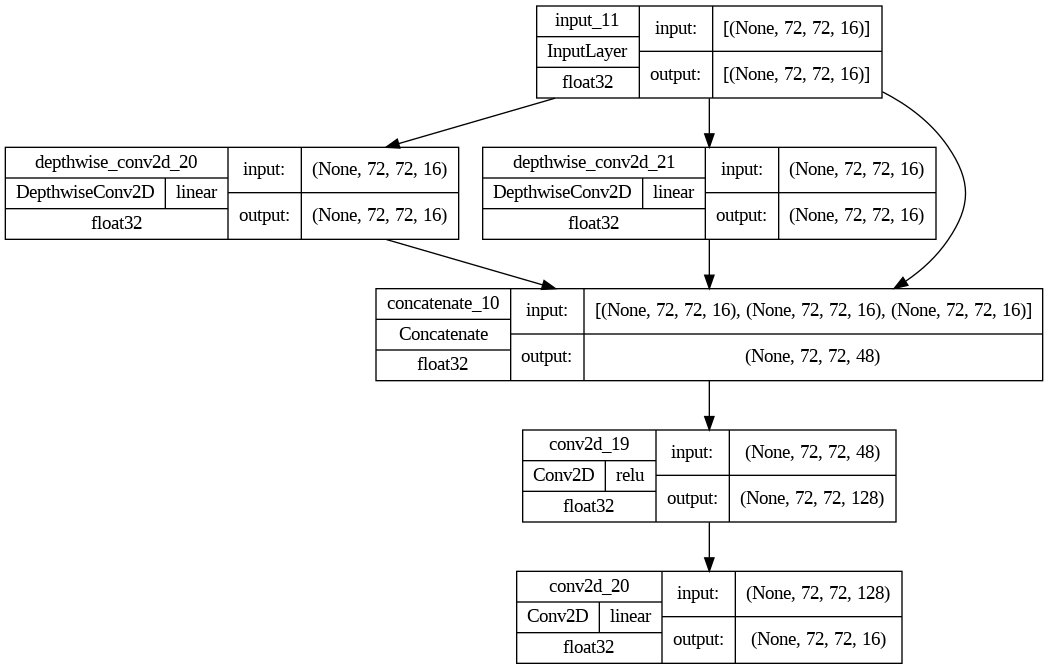

In [52]:
keras.utils.plot_model(model_step,show_shapes=True,show_dtype=True,show_layer_activations=True)

2. Initialize:

In [187]:
grid=CA(target_img)

Seed and target initialized


3. Train:

In [ ]:
grid.train(500)

Watch it grow for n steps:<br>(If you use a number > 100, you will see the instability when it grows past the number of steps it was trained for)

In [ ]:
grid.grow(100)

To save weights:

To load past weights:<br>
Click the folder icon and upload the weights file to colab. Insert the path below.

In [ ]:
grid=CA(target_img)
model_step.load_weights('/content/lizard_500.h5') # <- put your path here

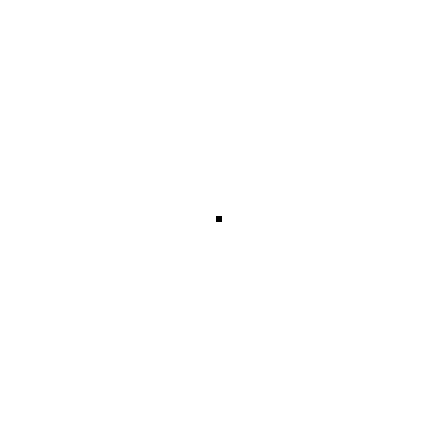

Time step  1


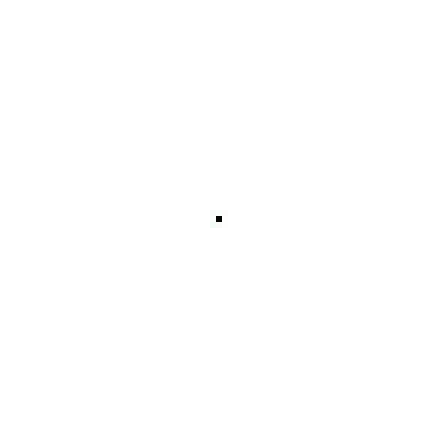

Time step  2


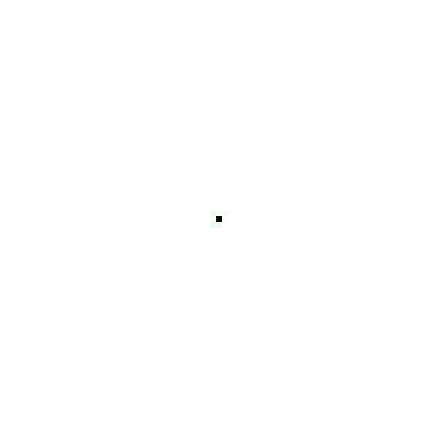

Time step  3


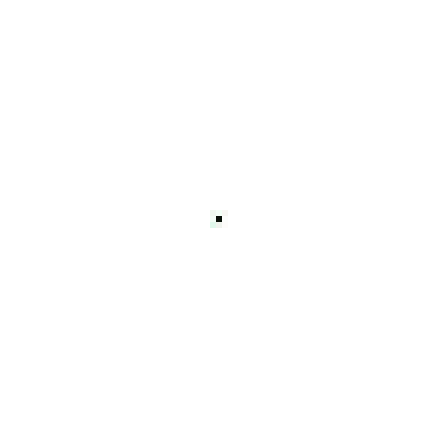

Time step  4


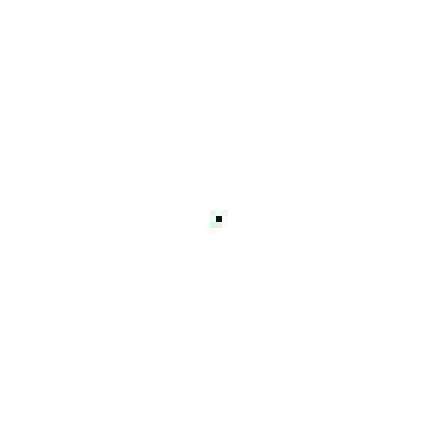

Time step  5


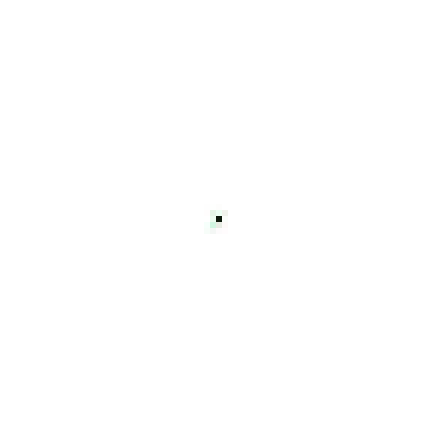

Time step  6


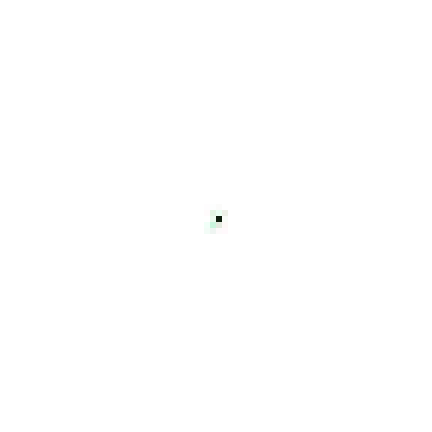

Time step  7


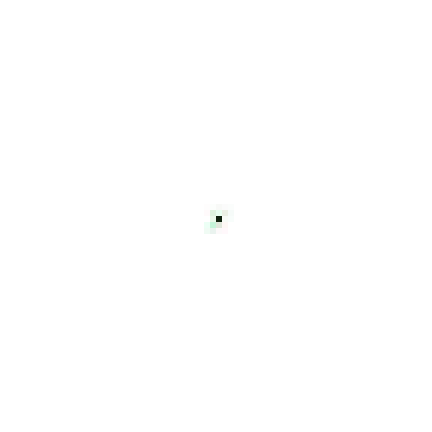

Time step  8


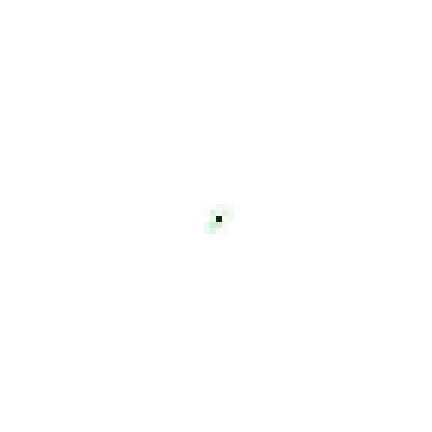

Time step  9


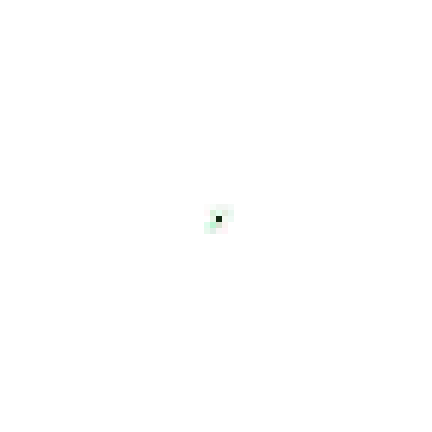

Time step  10


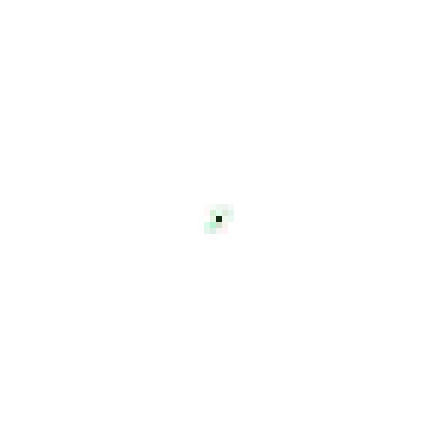

Time step  11


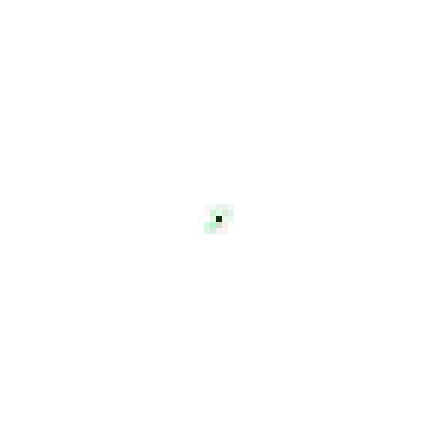

Time step  12


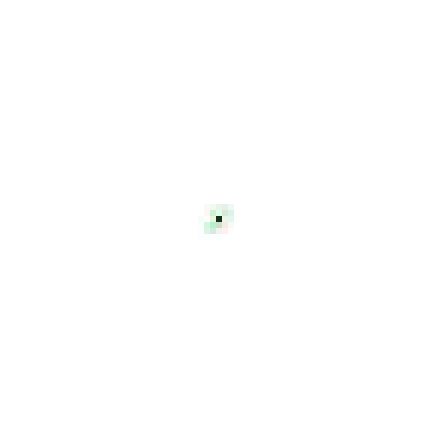

Time step  13


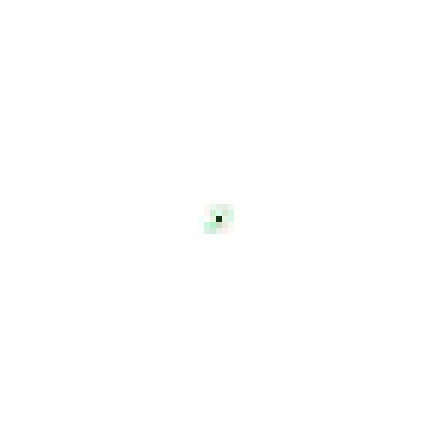

Time step  14


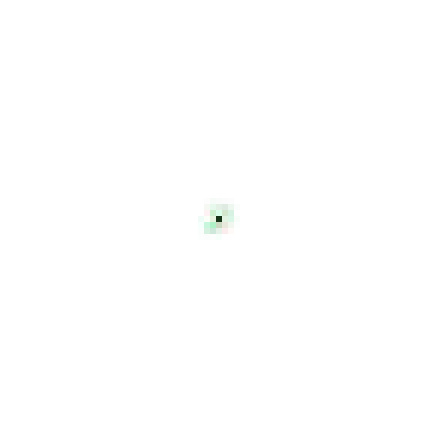

Time step  15


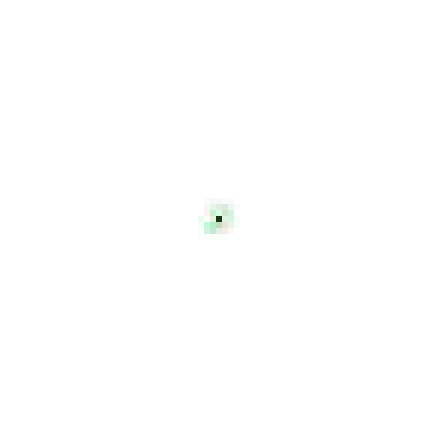

Time step  16


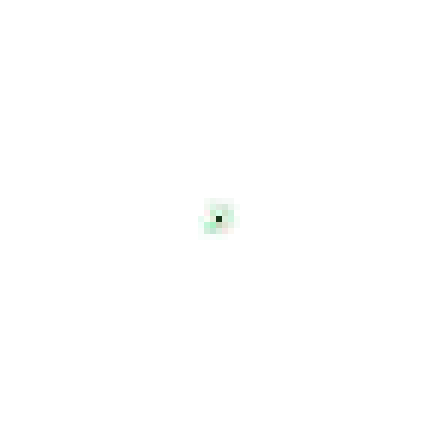

Time step  17


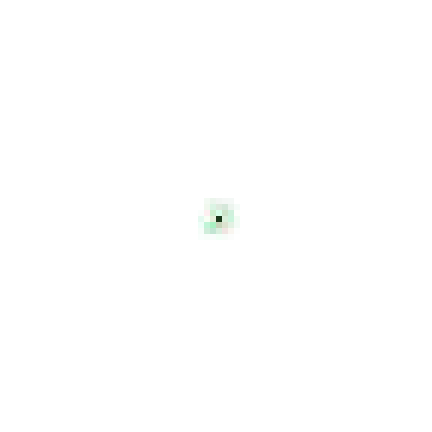

Time step  18


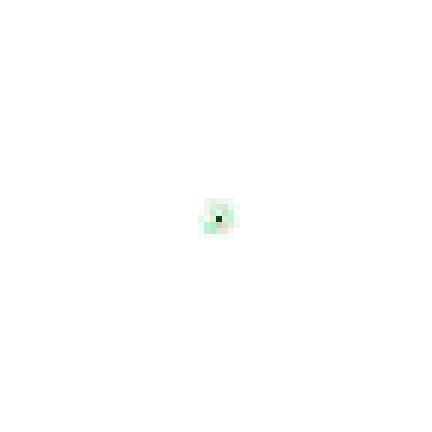

Time step  19


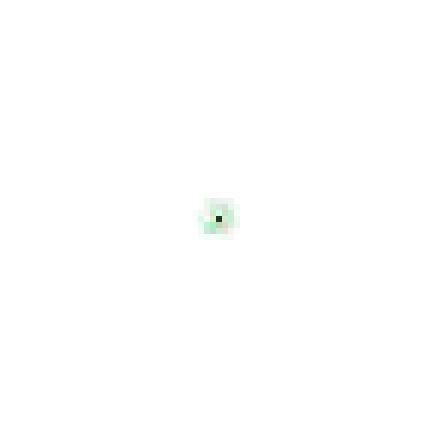

Time step  20


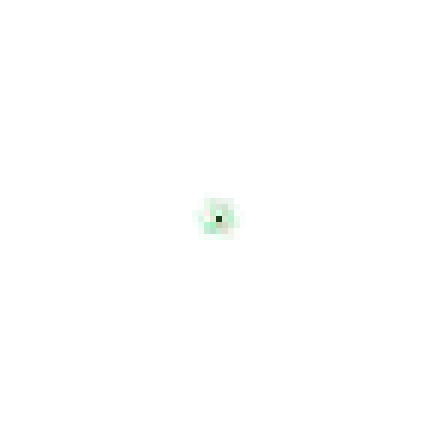

Time step  21


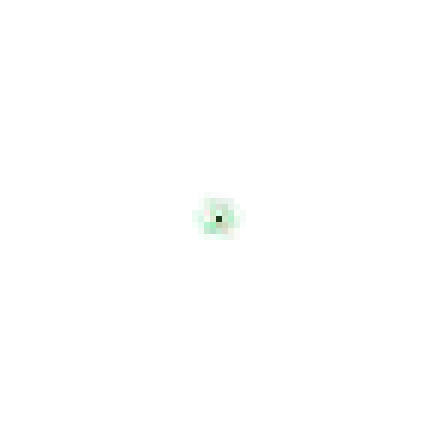

Time step  22


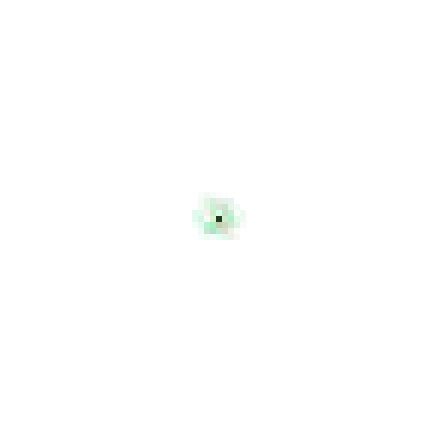

Time step  23


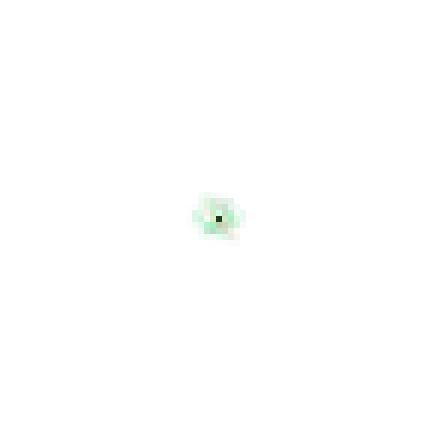

Time step  24


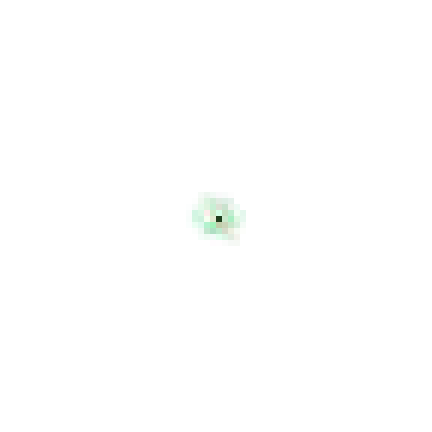

Time step  25


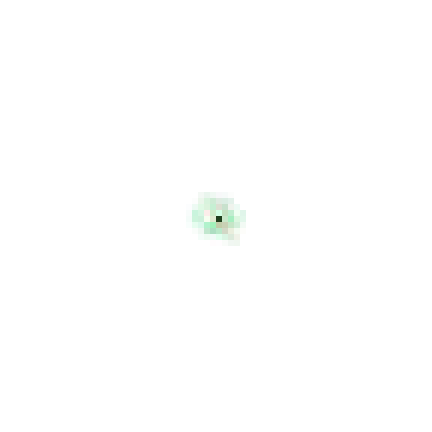

Time step  26


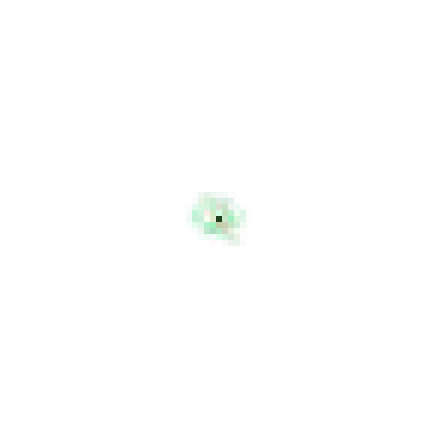

Time step  27


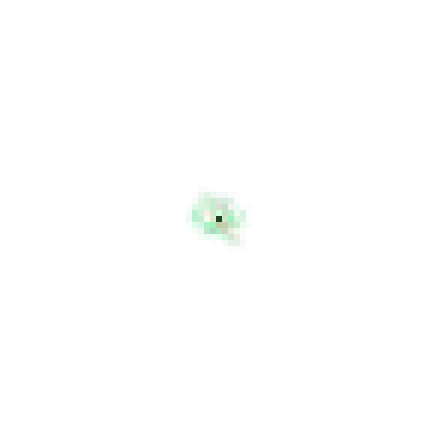

Time step  28


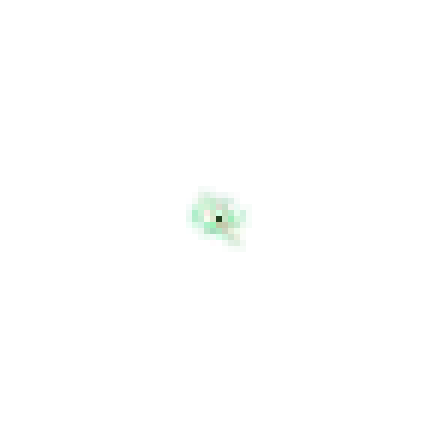

Time step  29


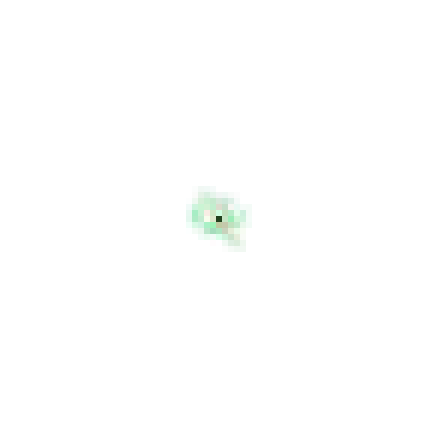

Time step  30


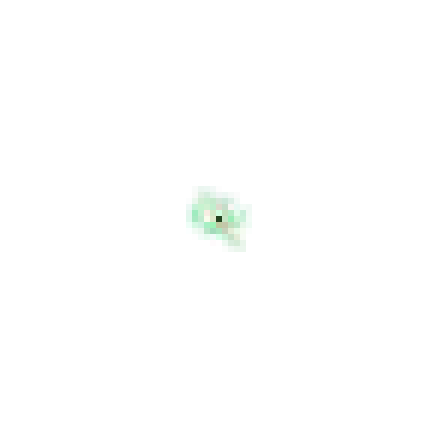

Time step  31


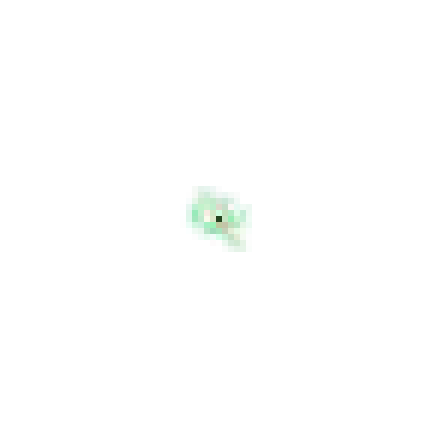

Time step  32


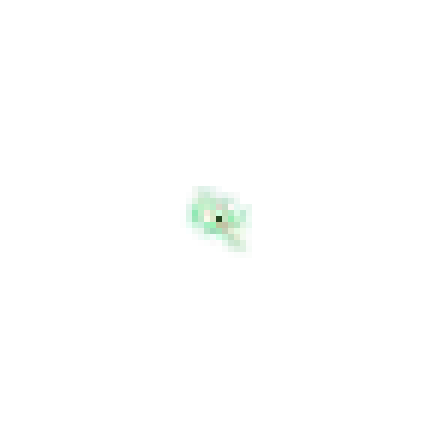

Time step  33


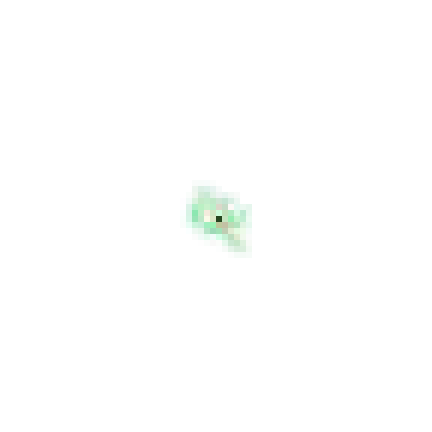

Time step  34


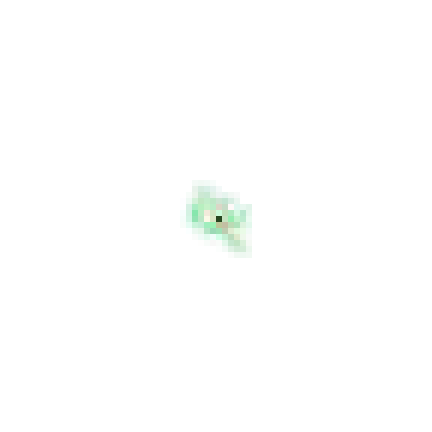

Time step  35


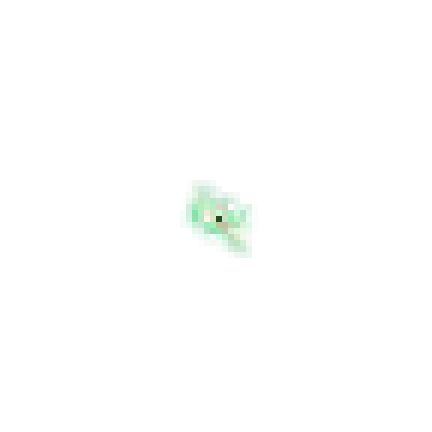

Time step  36


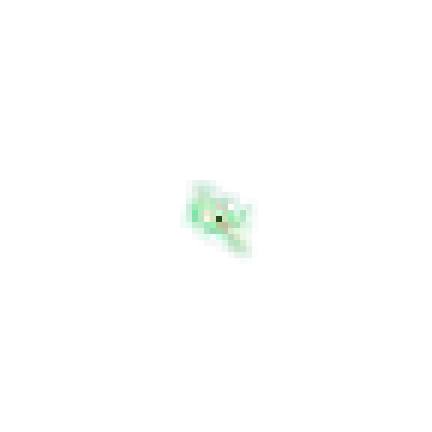

Time step  37


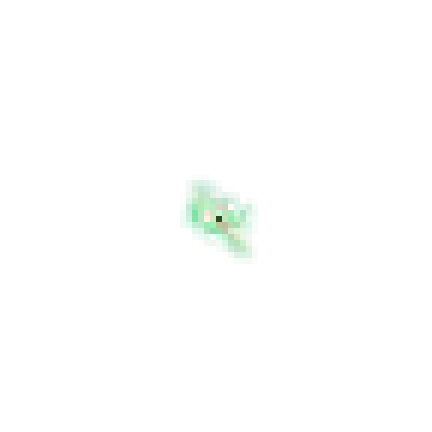

Time step  38


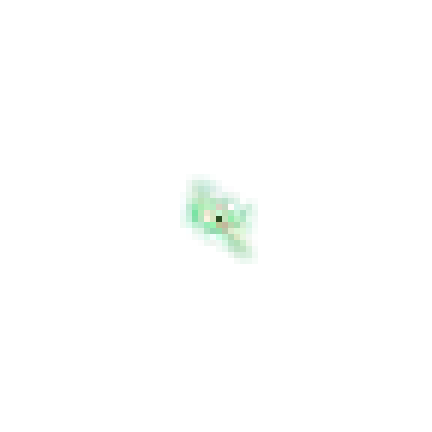

Time step  39


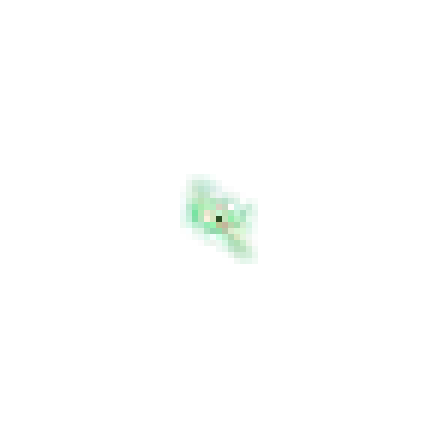

Time step  40


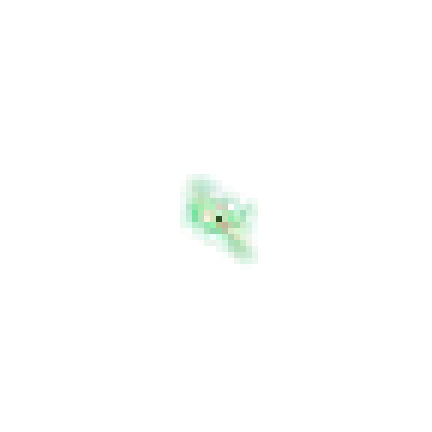

Time step  41


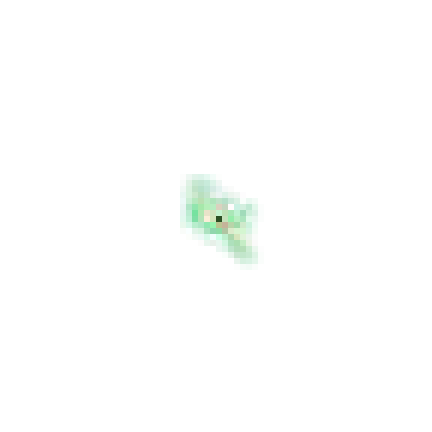

Time step  42


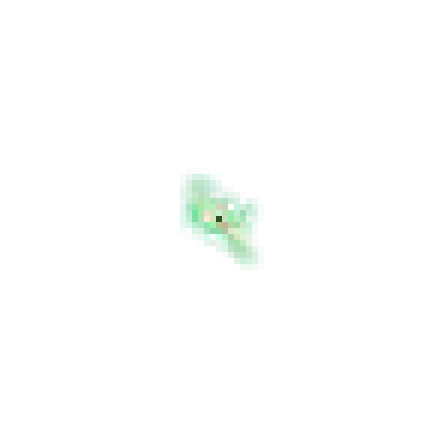

Time step  43


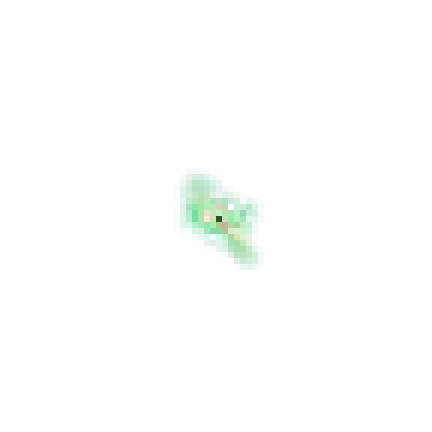

Time step  44


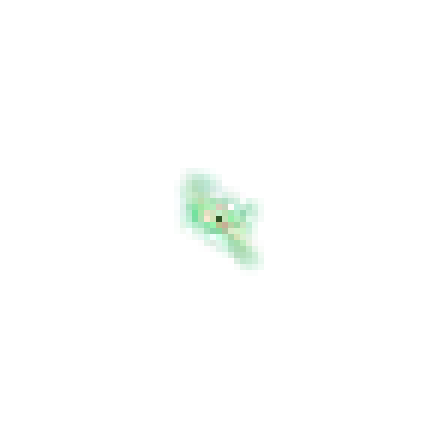

Time step  45


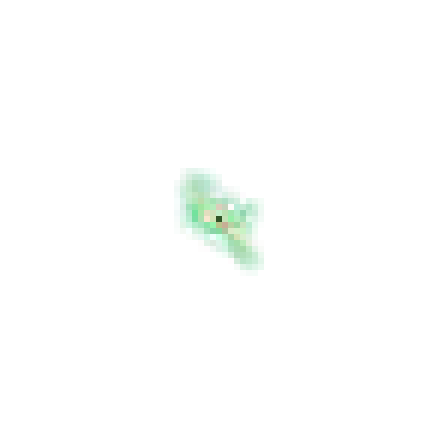

Time step  46


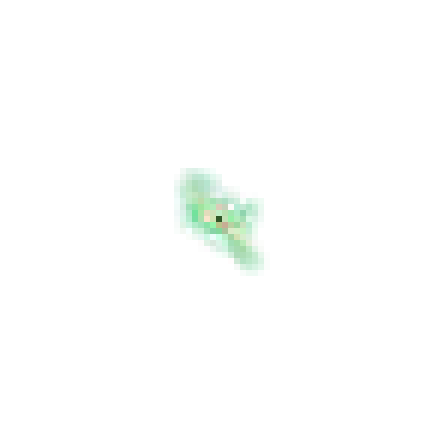

Time step  47


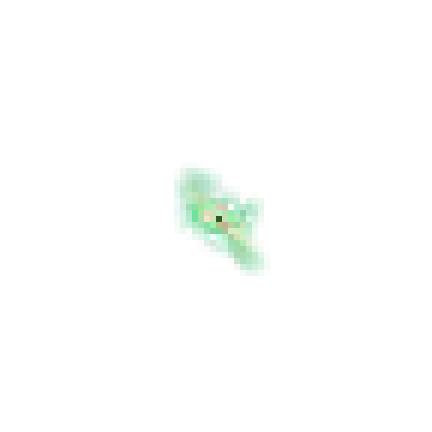

Time step  48


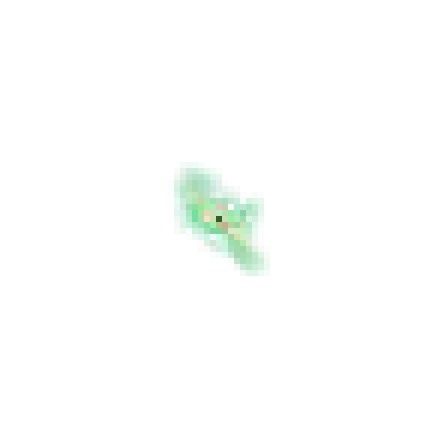

Time step  49


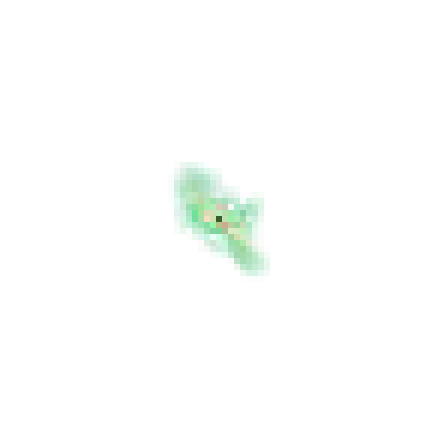

Time step  50


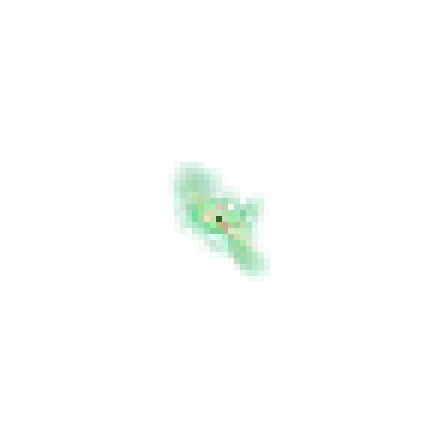

Time step  51


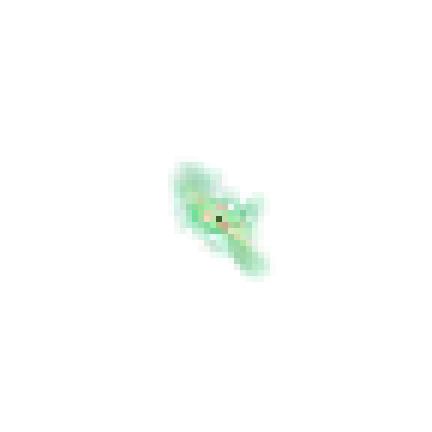

Time step  52


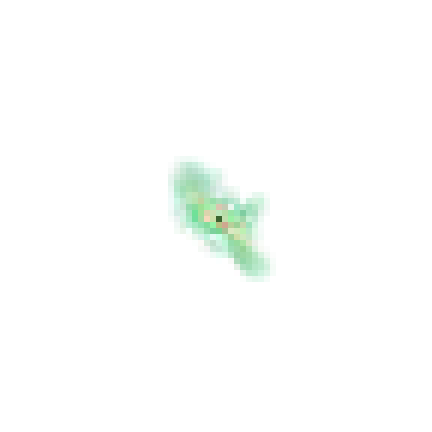

Time step  53


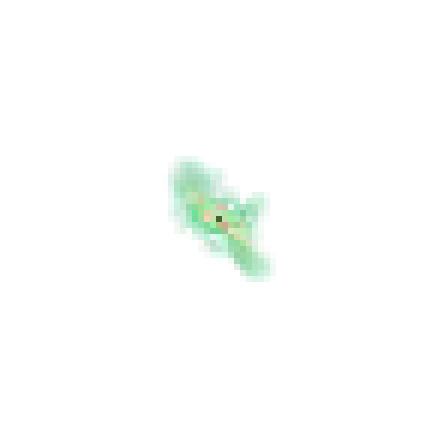

Time step  54


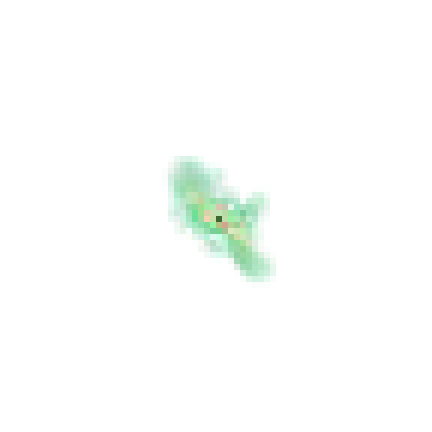

Time step  55


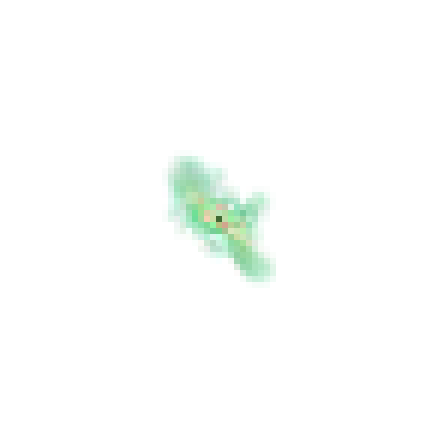

Time step  56


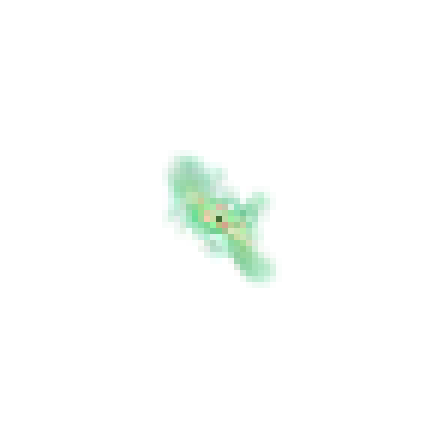

Time step  57


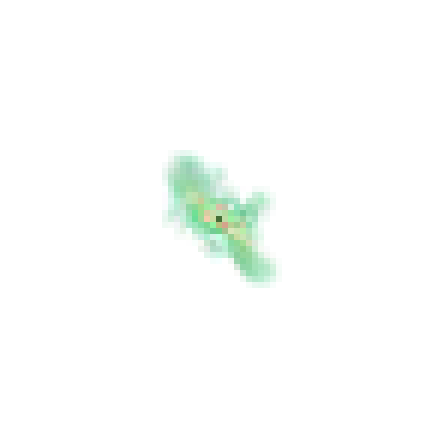

Time step  58


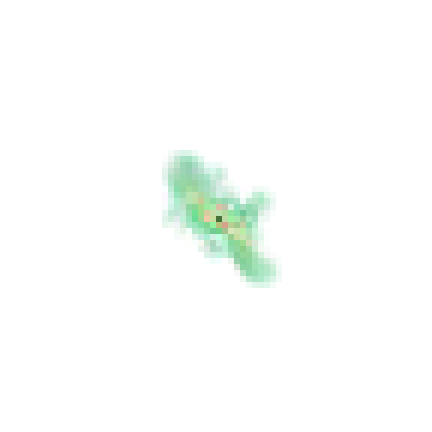

Time step  59


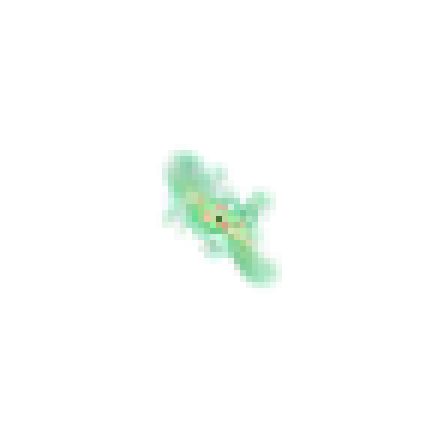

Time step  60


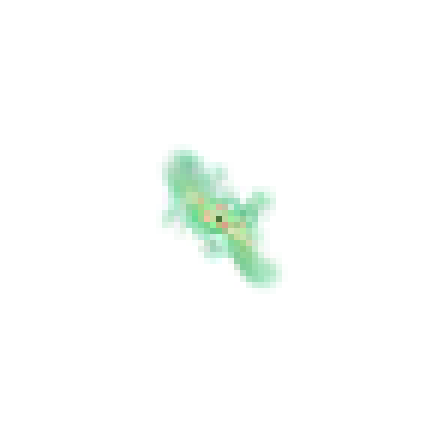

Time step  61


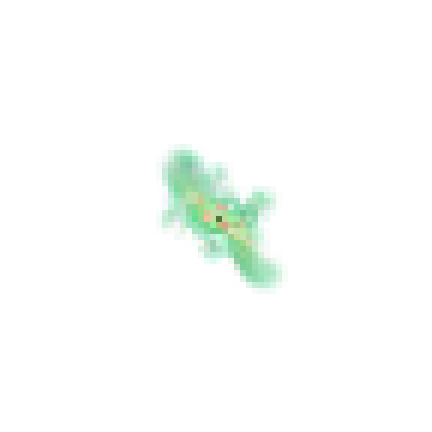

Time step  62


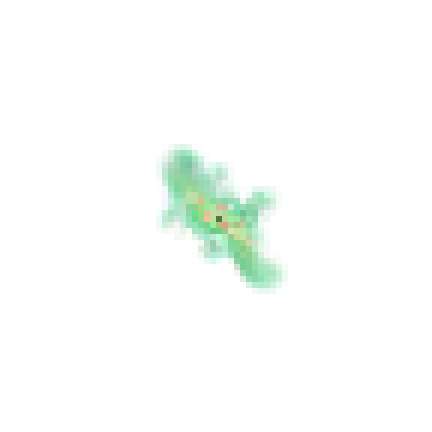

Time step  63


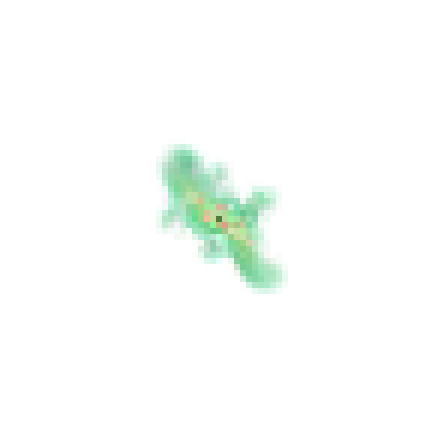

Time step  64


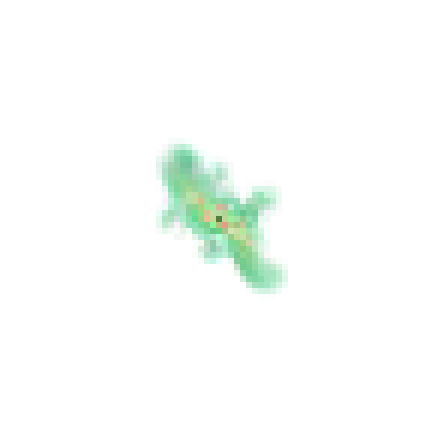

Time step  65


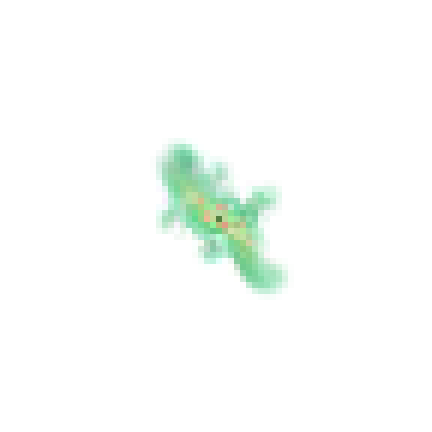

Time step  66


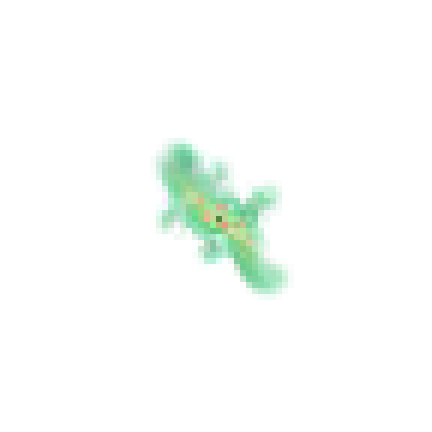

Time step  67


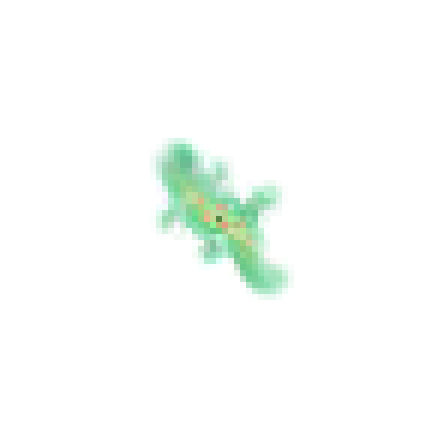

Time step  68


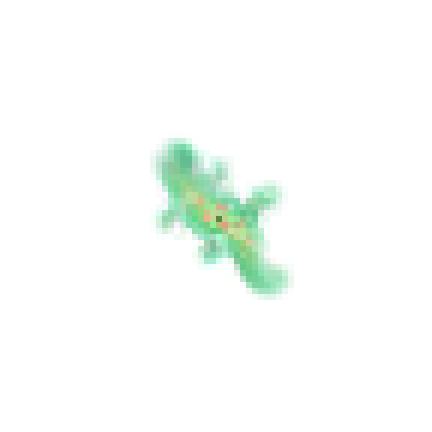

Time step  69


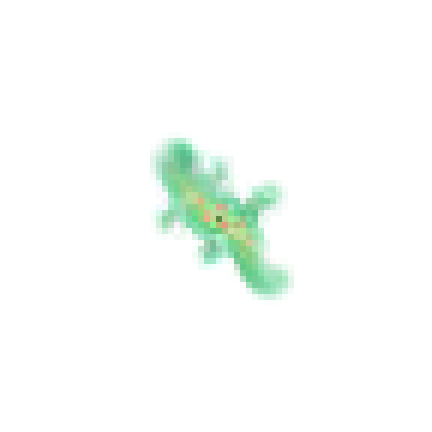

Time step  70


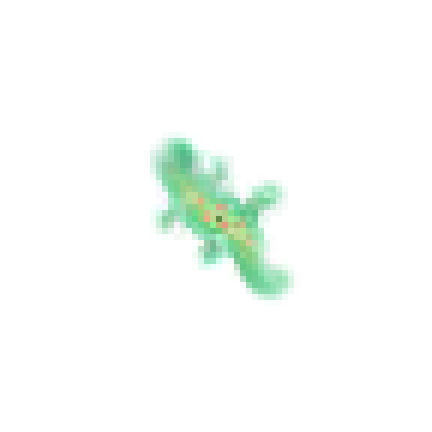

Time step  71


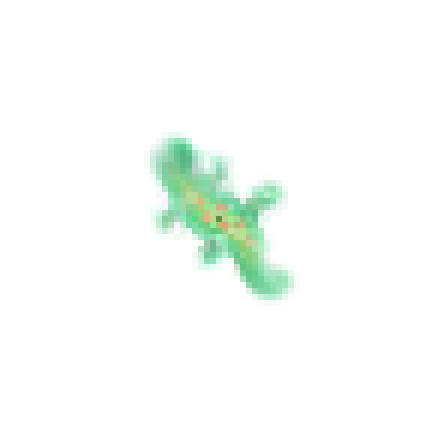

Time step  72


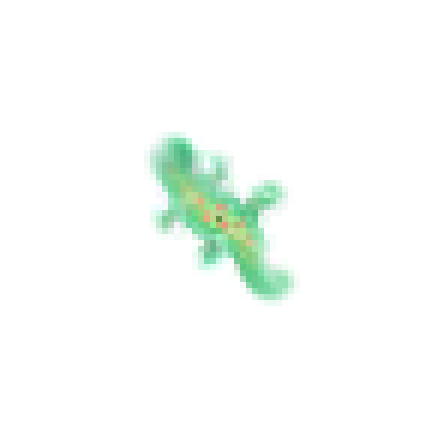

Time step  73


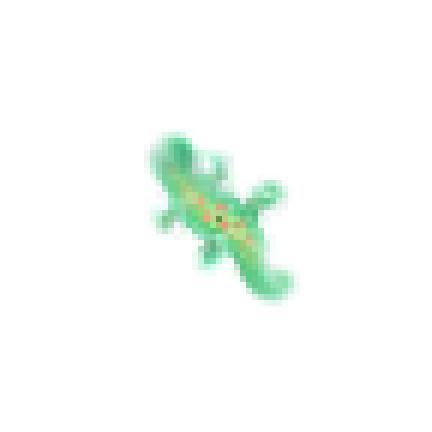

Time step  74


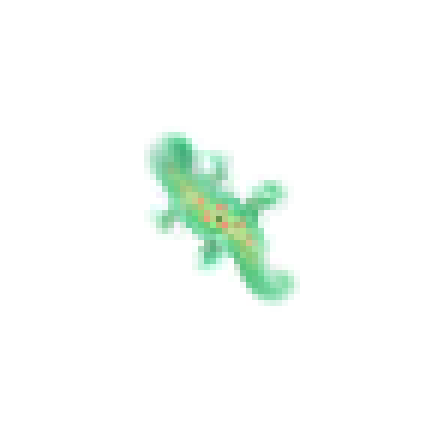

Time step  75


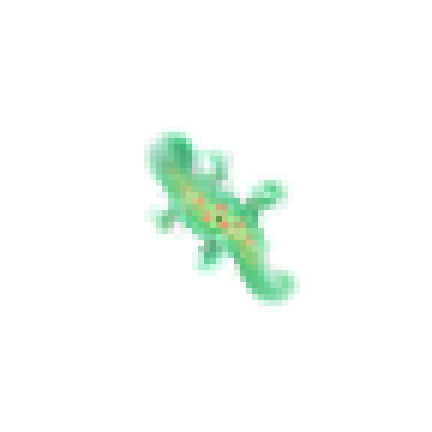

Time step  76


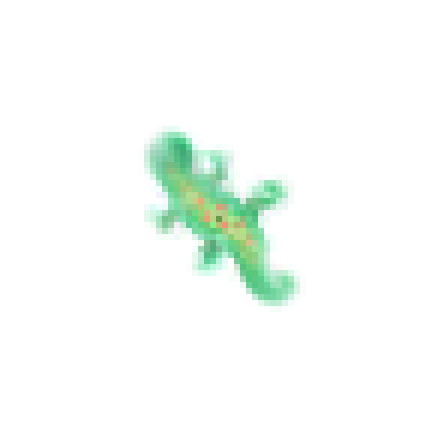

Time step  77


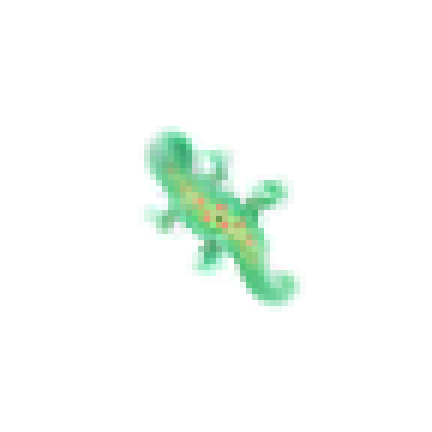

Time step  78


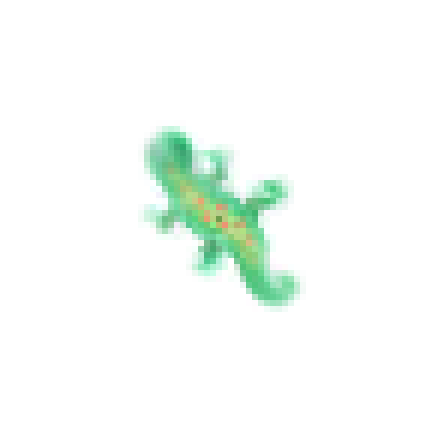

Time step  79


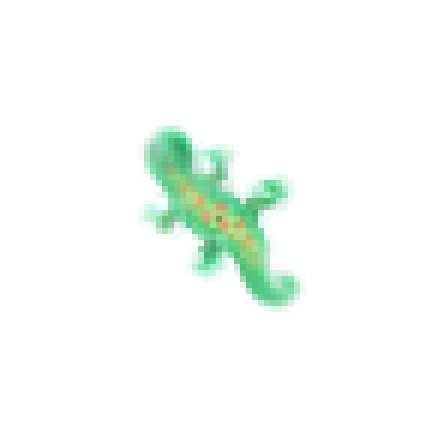

Time step  80


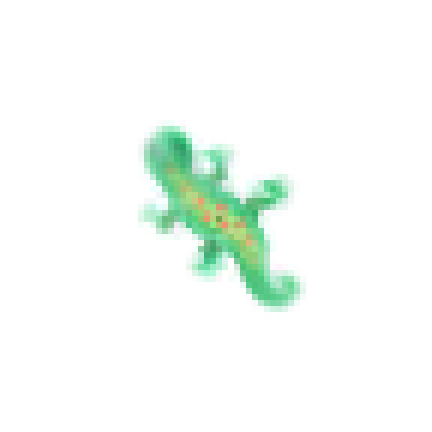

Time step  81


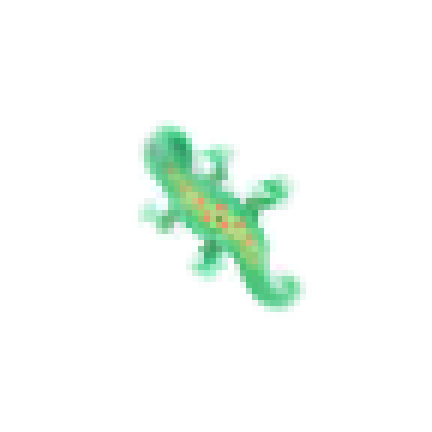

Time step  82


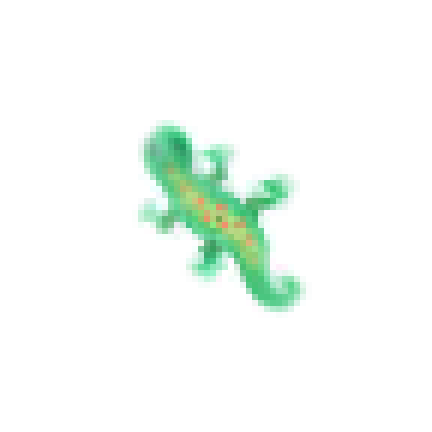

Time step  83


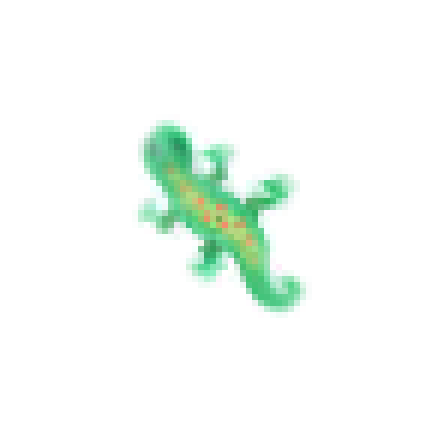

Time step  84


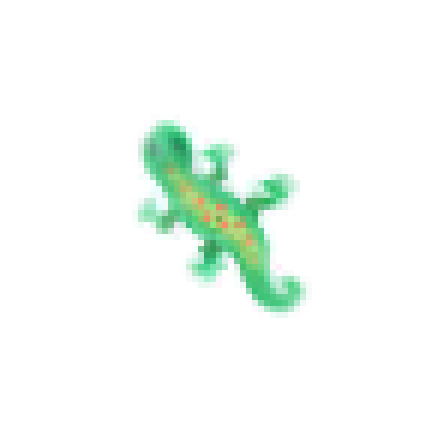

Time step  85


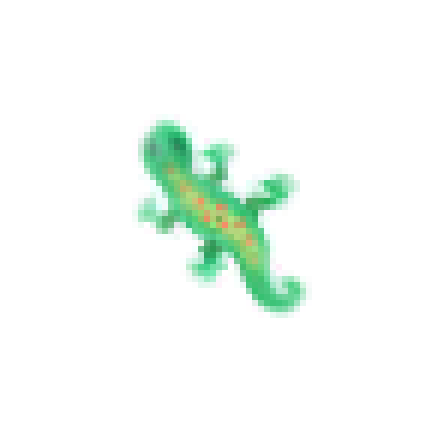

Time step  86


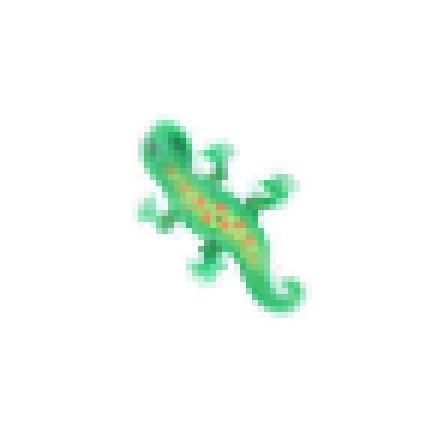

Time step  87


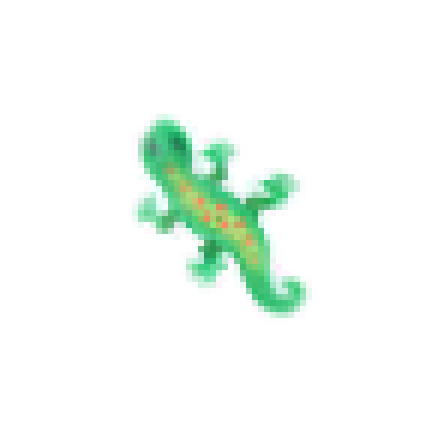

Time step  88


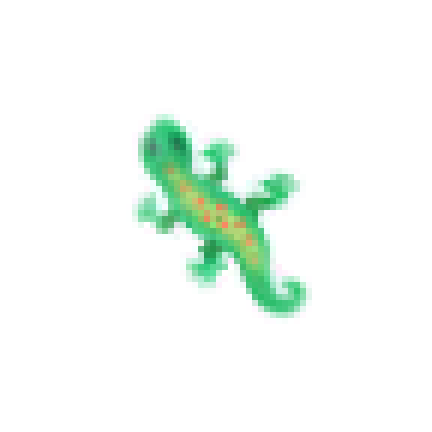

Time step  89


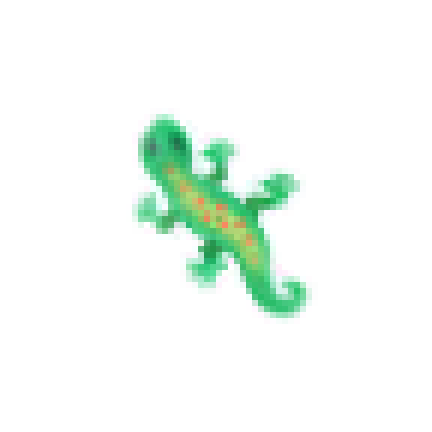

Time step  90


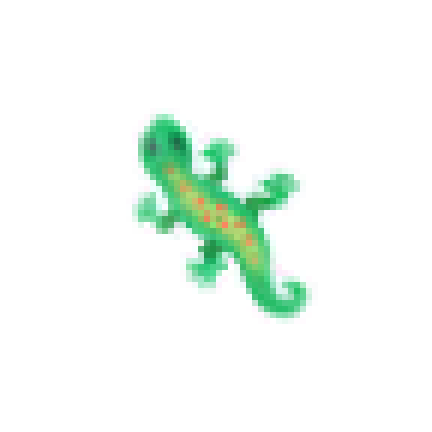

Time step  91


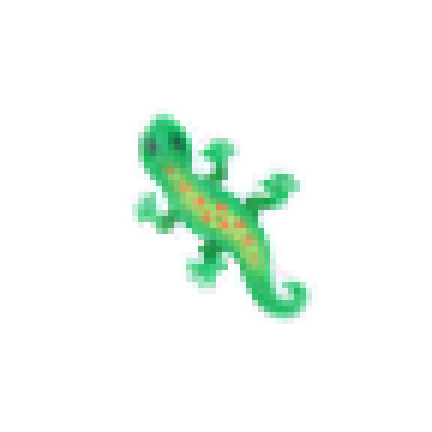

Time step  92


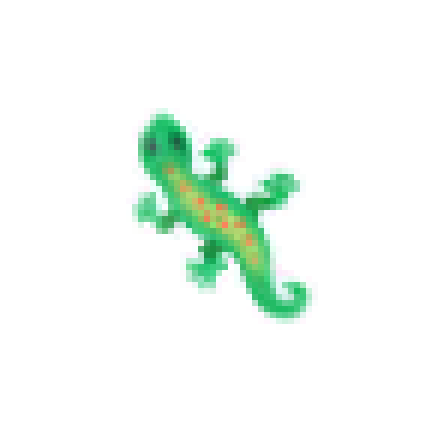

Time step  93


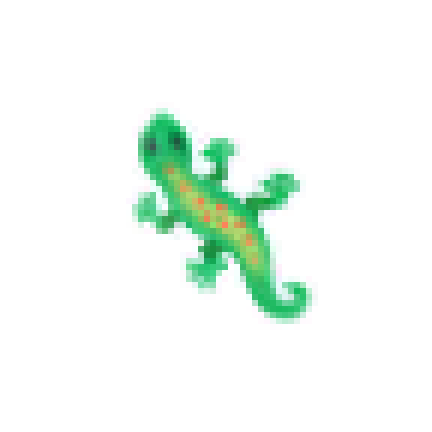

Time step  94


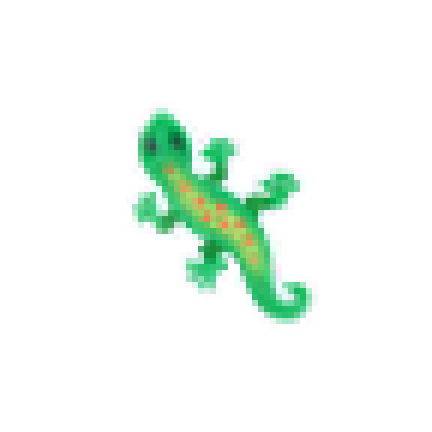

Time step  95


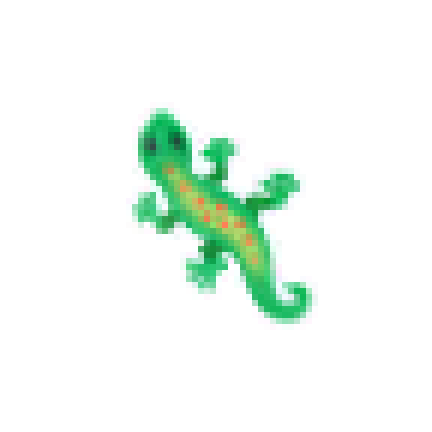

Time step  96


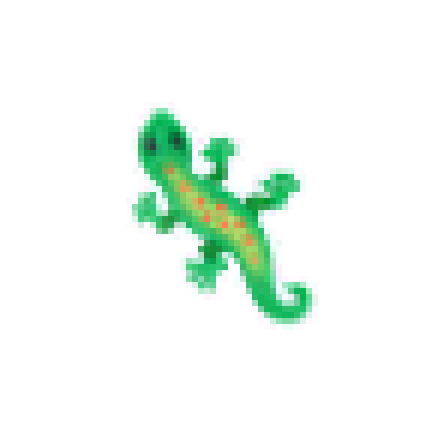

Time step  97


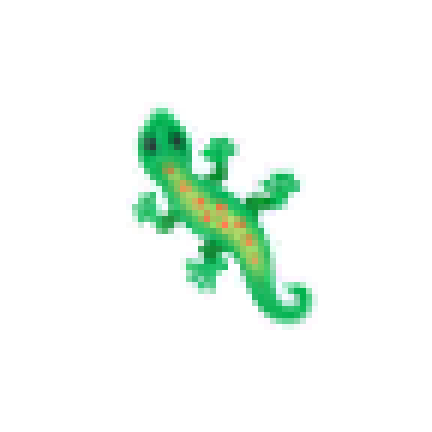

Time step  98


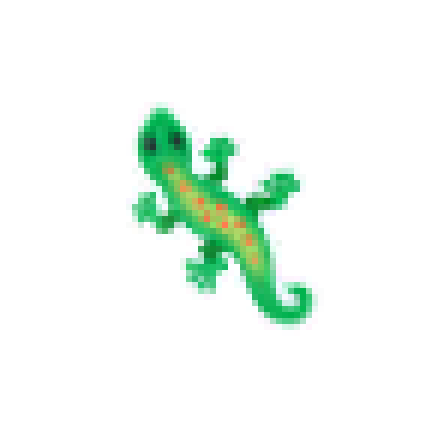

Time step  99


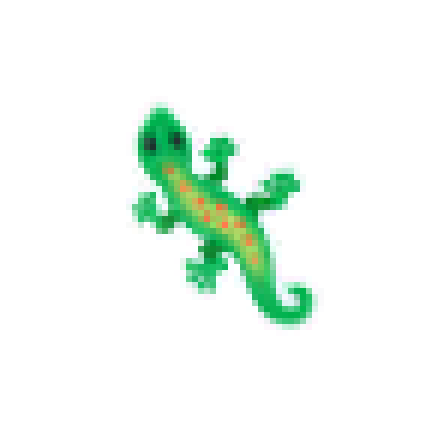

Time step  100


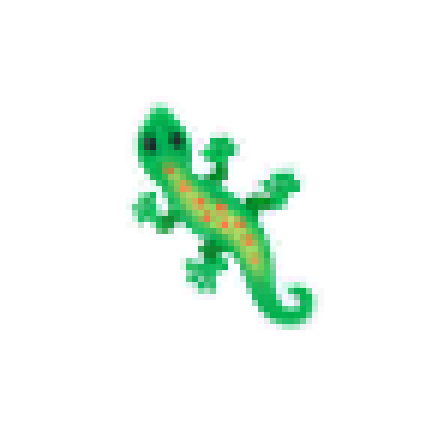

Current Loss:  0.00027199162


In [12]:
grid.grow(100)

To save weights:

In [13]:
#model_step.save_weights('<put name here>.h5')